# Homework Assignment 3

## Exercise 1

The function that implements Netown's method for minimization is

In [17]:
function newtmin(obj,x0,method;eps=1e-8,maxIts=1000,optTol=1e-8,r=0.9,c1=1e-4,c2=0.9)
    # Minimize a function f using Netown's method.
    #obj: a function that evaluates the objective values, gradient and Hessian at a point x, i.e., (f,g,H)=obj(x)
    #x0: starting point
    #maxIts: maximum number of iterations
    #optTol: optimality toleracne based on ||grad(x)||<=optTol*||grad(x0)||
    if method=="newton"
        g=obj(x0)[2]
        H=obj(x0)[3]
        its=0;g0=g;x=x0
        G=Float64[]
        while norm(g)>optTol && its <maxIts
            push!(G,norm(g))
            x=x-H\g
            its=its+1
            g=obj(x)[2]
            H=obj(x)[3]
        end
    elseif method=="modified1"
        g=obj(x0)[2]
        H=obj(x0)[3]
        its=0;g0=g;x=x0
        G=Float64[]
        while norm(g)>optTol && its<maxIts
            push!(G,norm(g))
            D,V=eig(H)
            H=V*Diagonal(map(x->1/max(abs(x),eps),D))*V'
            d=-H*g
            x=btls(obj,x,d,g,1,r,c1,c2)
            its=its+1
            g=obj(x)[2]
            H=obj(x)[3]
        end
    elseif method=="modified2"
        g=obj(x0)[2]
        H=obj(x0)[3]
        its=0;g0=g;x=x0
        G=Float64[]
        while norm(g)>optTol*norm(g0) && its<maxIts
            push!(G,norm(g))
            D,V=eig(H)
            H=V*Diagonal(map(x->1/max(abs(x),eps),D))*V'
            d=-H*g
            x=btls(obj,x,d,g,1,r,c1,c2)
            its=its+1
            g=obj(x)[2]
            H=obj(x)[3]
        end
    elseif method=="bfgs"
        f0,g0,H0=obj(x0)
        D,V=eig(H0)
        H0=V*Diagonal(map(x->1/max(x,1),D))*V'
        its=0;ng=norm(g0)
        G=Float64[]
        while norm(g0)>optTol*ng && its<maxIts
            push!(G,norm(g0))
            d=-H0*g0
            x=btls(obj,x0,d,g0,2,r,c1,c2)
            g=obj(x)[2]
            s=x-x0; y=g-g0
            rho=1/dot(y,s)
            H=(eye(H0)-rho*s*y')*H0*(eye(H0)-rho*y*s')+rho*s*s'
            its=its+1
            x0=x;g0=g;H0=H
        end
    else 
        println("Please enter netwon, modified1, modified2 or bfgs!")
    end
    return x,its,G
end

function btls(obj,x,d,g,method,r,c1,c2;a=1,maxIts0=100,maxIts1=25)
    if method==1
        for i=1:maxIts0
            a=a*r
            if obj(x+a*d)[1]<=obj(x)[1]+a*c1*dot(g,d)
                break
            end
        end
    elseif  method==2
        for i=1:maxIts1
            a=a*r
            if obj(x+a*d)[1]<=obj(x)[1]+c1*a*dot(g,d) && dot(d,obj(x+a*d)[2])>=c2*dot(d,g)
                break
            end
        end
    else
        println("Please enter 1 or 2!")
    end
    x=x+a*d
    return x
end

function p2obj(p)
    function obj(x)
        return (p.obj(x),p.grd(x),p.hes(x))
    end
    return obj
end

p2obj (generic function with 1 method)

A test script is as below:

In [18]:
function obj0(x)
    f=x[1]^4+2x[1]^2+(x[2]-4)^2
    g=[4x[1]^3+4x[1],2x[2]-8]
    H=[12x[1]^2+4 0;0 2]
    return f,g,H
end

@printf("%-20s %5s %12s %12s %12s\n", "Name","its","f(x0)","|∇f(x0)|","cond(∇²f(x0))")
x0=[20, 50]
x,its,G=newtmin(obj0,x0,"newton";maxIts=100,optTol=1e-12)
@printf("%-20s %5i %12.2e %12.2e %12.2e\n", "Pure Newton",
its, obj0(x)[1],norm(obj0(x)[2]),cond(obj0(x)[3]))
x,its,G=newtmin(obj0,x0,"modified1";maxIts=100,optTol=1e-12)
@printf("%-20s %5i %12.2e %12.2e %12.2e\n","Modified Newton",
its, obj0(x)[1],norm(obj0(x)[2]),cond(obj0(x)[3]))
x,its,G=newtmin(obj0,x0,"modified2";maxIts=100,optTol=1e-12)
@printf("%-20s %5i %12.2e %12.2e %12.2e\n","Modified Newton",
its, obj0(x)[1],norm(obj0(x)[2]),cond(obj0(x)[3]))
x,its,G=newtmin(obj0,x0,"bfgs";maxIts=100,optTol=1e-12)
@printf("%-20s %5i %12.2e %12.2e %12.2e\n", "BFGS",
its, obj0(x)[1],norm(obj0(x)[2]),cond(obj0(x)[3]))

Name                   its        f(x0)     |∇f(x0)| cond(∇²f(x0))
Pure Newton             12     1.10e-42     2.96e-21     2.00e+00
Modified Newton         23     1.33e-27     1.03e-13     2.00e+00
Modified Newton         18     1.33e-17     1.03e-08     2.00e+00
BFGS                    22     1.02e-17     9.05e-09     2.00e+00


From the results above, the Newton's method returns a minimizer within the correct tolerance.

For Tom's Problem, a simple result (Pure Newton's method, Modified Newton's method and quasi-Newton BGGS method) is listed below. 

In [3]:
using Toms566
@printf("%3s %3s %12s %5s %12s %5s %12s %5s %12s\n",
"No.","n","f(x0)","Its","f(x*)","Its","f(x*)","Its","f(x*)")
for i=1:18
    p=Problem(i)
    x1,its1,G1=newtmin(p2obj(p),p.x0,"newton",maxIts=100)
    x2,its2,G2=newtmin(p2obj(p),p.x0,"modified1",maxIts=1000)
    x4,its4,G4=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-6)
    @printf("%3i %3i %12.2e %5i %12.2e %5i %12.2e %5i %12.2e\n",
    i,p.n,p.obj(p.x0),its1,p.obj(x1),its2,p.obj(x2),its4,p.obj(x4))
end

No.   n        f(x0)   Its        f(x*)   Its        f(x*)   Its        f(x*)
  1   3     2.50e+03    33     8.17e-23   164     3.55e-19    42     3.58e-09
  2   6     7.79e-01    89          Inf  1000     5.94e-04   134     6.49e-12
  3   3     3.89e-06     2     1.13e-08     6     1.13e-08    25     1.13e-08
  4   2     1.14e+00    16     2.00e+00    94     5.41e-27   179     3.12e-13
  5   3     1.03e+03     9     5.06e-23    28     4.16e-17    50     1.14e-09
  6  40     9.39e+10   100     5.04e+03  1000     1.73e+01    49     1.05e+03
  7   9     3.00e+01   100     3.50e+23  1000     4.32e-04   114     6.19e-06
  8  60     5.45e+09    20     5.25e-04    26     5.25e-04    30     4.81e+01
  9  65     2.87e+05   100     1.25e+04  1000     8.80e+01    62     8.81e+01
 10   2     1.00e+12   100     1.47e+12    23     7.89e-31   116     2.79e-13
 11   4     7.93e+06   100     1.63e+27    46     8.58e+04    36     8.58e+04
 12   3     1.21e+01   100    9.52e+237    30     4.62e-19    55

From the results above, the Pure Newton's method does not work good for some of the Tom's problems; the modified Newton's and the BFGS are more stable.

For the Modified Newton's method, the results are listed below:

In [4]:
using Toms566
using Base.Test

@printf("%3s  %-30s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
for i=1:18
    p = Problem(i)
    x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=2000)
    @printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
    i, p.name, p.n, its, p.obj(x),
            norm(p.grd(x)),
            cond(p.hes(x)))
end

No.  Name                             n   Its         f(x)      |∇f(x)| cond(∇²f(x))
  1  Hellical valley                  3   164     3.55e-19     6.86e-09     4.94e+02
  2  Bigg's EXP6                      6  2000     3.45e-04     1.13e-03     1.53e+02
  3  Gaussian                         3     6     1.13e-08     7.45e-09     5.13e+01
  4  Powell                           2    94     5.41e-27     7.42e-09     6.88e+17
  5  Box 3-dim                        3    28     4.16e-17     5.84e-09     8.34e+03
  6  Variably dimensioned            40  2000     6.01e+00     9.68e+00     9.06e+03
  7  Watson                           9  2000     2.02e-04     1.71e-02     3.75e+01
  8  Penalty I                       60    26     5.25e-04     3.81e-09     6.46e+03
  9  Penalty II                      65  2000     8.80e+01     5.87e-03     1.09e+06
 10  Brown badly scaled               2    23     7.89e-31     1.78e-09     1.00e+12
 11  Brown and Denis                  4    46     8.58e+04     5.

For the 2nd, 6th and 9th Problems:

In [5]:
@printf("%3s  %-30s %3s %8s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(2)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=1e6)
@printf("%3i  %-30s %3i %8i %12.2e %12.2e %12.2e\n",
2, p.name, p.n, its, p.obj(x), norm(p.grd(x)), cond(p.hes(x)))

p=Problem(6)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=200000)
@printf("%3i  %-30s %3i %8i %12.2e %12.2e %12.2e\n",
6, p.name, p.n, its, p.obj(x), norm(p.grd(x)),cond(p.hes(x)))

p = Problem(9)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=100000)
@printf("%3i  %-30s %3i %8i %12.2e %12.2e %12.2e\n",
9, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))

No.  Name                             n      Its         f(x)      |∇f(x)| cond(∇²f(x))
  2  Bigg's EXP6                      6   837459     2.32e-12     1.00e-08     3.98e+01
  6  Variably dimensioned            40   100389     2.42e-17     1.00e-08     9.04e+03
  9  Penalty II                      65    25375     8.80e+01     9.95e-09     1.00e+04


For the 7th Problem:

In [8]:
@printf("%3s  %-10s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(7)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=100000)
@printf("%3i  %-10s %3i %5i %12.2e %12.2e %12.2e\n",
7, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))

x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=1000000)
@printf("%3i  %-10s %3i %5i %12.2e %12.2e %12.2e\n",
7, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

No.  Name         n   Its         f(x)      |∇f(x)| cond(∇²f(x))
  7  Watson       9 100000     3.53e-05     7.54e-04     3.80e+01
  7  Watson       9 1000000     2.04e-05     1.15e-04     3.81e+01


For the 14th Problem:

In [10]:
@printf("%3s  %-20s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(14)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=100000)
@printf("%3i  %-20s %3i %5i %12.2e %12.2e %12.2e\n",
14, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))

x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=200000)
@printf("%3i  %-20s %3i %5i %12.2e %12.2e %12.2e\n",
14, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

No.  Name                   n   Its         f(x)      |∇f(x)| cond(∇²f(x))
 14  Extended rosenbrock   40 100000     2.57e-01     6.37e-01     2.06e+04
 14  Extended rosenbrock   40 200000     2.51e-01     8.64e-01     5.11e+05


For the 15th Problem:

In [11]:
@printf("%3s  %-30s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(15)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=10000)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
15, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))

x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=200000)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
15, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

No.  Name                             n   Its         f(x)      |∇f(x)| cond(∇²f(x))
 15  Extended Powell singular        60 10000     4.98e-04     1.62e-02     2.06e+04
 15  Extended Powell singular        60 200000     2.19e-04     6.99e-03     6.30e+05


For the 18th Problem:

In [13]:
@printf("%3s  %-15s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(18)
x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=1000)
@printf("%3i  %-15s %3i %5i %12.2e %12.2e %12.2e\n",
18, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))

x,its,G=newtmin(p2obj(p),p.x0,"modified1",maxIts=10000)
@printf("%3i  %-15s %3i %5i %12.2e %12.2e %12.2e\n",
18, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

No.  Name              n   Its         f(x)      |∇f(x)| cond(∇²f(x))
 18  Chebyquad        50  1000     6.67e-03     3.56e-02     3.57e+02
 18  Chebyquad        50 10000     6.44e-03     4.71e-03     1.44e+03


From the results above, we can see that the Modified Newton's method can converge for most of the problems. However, some of them are in a pretty slow pace.

For the BFGS method,

In [7]:
using Toms566
using Base.Test

@printf("%3s  %-30s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
for i=1:18
    p = Problem(i)
    x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-6)
    @printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
    i, p.name, p.n, its, p.obj(x),norm(p.grd(x)), cond(p.hes(x)))
end

No.  Name                             n   Its         f(x)      |∇f(x)| cond(∇²f(x))
  1  Hellical valley                  3    42     3.58e-09     1.13e-03     4.93e+02
  2  Bigg's EXP6                      6   134     6.49e-12     6.64e-07     3.98e+01
  3  Gaussian                         3    25     1.13e-08     5.13e-09     5.13e+01
  4  Powell                           2   179     3.12e-13     1.33e-02     5.91e+17
  5  Box 3-dim                        3    50     1.14e-09     1.20e-04     8.34e+03
  6  Variably dimensioned            40    49     1.05e+03     7.20e+04     1.64e+04
  7  Watson                           9   114     6.19e-06     1.58e-04     3.80e+01
  8  Penalty I                       60    30     4.81e+01     7.44e+01     4.43e+00
  9  Penalty II                      65    62     8.81e+01     3.26e-01     4.84e+02
 10  Brown badly scaled               2   116     2.79e-13     1.06e+00     1.00e+12
 11  Brown and Denis                  4    36     8.58e+04     1.

If I choose different $\rho$ and optTol, then I can get better results:

In [8]:
using Toms566
using Base.Test

@printf("%3s  %-30s %3s %5s %12s %12s %12s\n","No.","Name","n","Its",
        "f(x)","|∇f(x)|","cond(∇²f(x))")
p = Problem(1)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
1, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(2)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
2, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(3)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-7)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
3, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(4)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
4, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(5)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=1000,r=0.5,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
5, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(6)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=2000,r=0.5,optTol=1e-24)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
6, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(7)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.6,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
7, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(8)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=2000,r=0.5,optTol=1e-16)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
8, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(9)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-14)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
9, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(10)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.6,optTol=1e-16)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
10, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(11)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.9,optTol=1e-16)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
11, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(12)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-16)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
12, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(13)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.9,optTol=1e-12)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
13, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(14)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-15)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
14, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(15)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-18)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
15, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(16)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-16)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
16, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(17)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.5,optTol=1e-19)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
17, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

p = Problem(18)
x,its,G=newtmin(p2obj(p),p.x0,"bfgs",maxIts=10000,r=0.6,optTol=1e-10)
@printf("%3i  %-30s %3i %5i %12.2e %12.2e %12.2e\n",
18, p.name, p.n, its, p.obj(x),norm(p.grd(x)),cond(p.hes(x)))

No.  Name                             n   Its         f(x)      |∇f(x)| cond(∇²f(x))
  1  Hellical valley                  3    68     7.95e-25     1.69e-11     4.94e+02
  2  Bigg's EXP6                      6   163     2.13e-28     2.01e-14     3.98e+01
  3  Gaussian                         3    28     1.13e-08     6.37e-10     5.13e+01
  4  Powell                           2   209     3.38e-30     1.82e-10     6.88e+17
  5  Box 3-dim                        3    76     3.78e-25     1.20e-12     8.34e+03
  6  Variably dimensioned            40  1104     1.82e-30     6.61e-14     9.04e+03
  7  Watson                           9   312     1.40e-06     8.87e-13     3.80e+01
  8  Penalty I                       60   725     5.25e-04     7.49e-09     7.64e+03
  9  Penalty II                      65  7251     8.80e+01     3.19e-09     1.00e+04
 10  Brown badly scaled               2   170     0.00e+00     0.00e+00     1.00e+12
 11  Brown and Denis                  4    33     8.58e+04     1.

From the results above, we can see that by using the "BFGS" method, all the 18 problems can converge in the sense that $\|\text{gradient}\|<1e^{-8}$ . 

##Exercise 2

Apply the Newton code to solve the logistic regression problem:

In [19]:
using DataFrames
admission=readtable("binary.csv");
u=convert(Array,admission[:,2:3]);
y=convert(Array,admission[:,1]);
m=size(admission,1)

#Negative log-likelihood
function NL(x,u=u,y=y,m=m)
    s=0
    for i=1:m
        s=s-y[i]*(x[1]+x[2]*u[i,1]+x[3]*u[i,2])+log(1+exp(x[1]+x[2]*u[i,1]+x[3]*u[i,2]))
    end
    return(s)
end

#Gradient of negtive log-likelihood
function Df(x,u=u,y=y,m=m)
    s=zeros(3)
    for i=1:m
        s=s-(y[i]-1/(1+exp(-x[1]-x[2]*u[i,1]-x[3]*u[i,2])))*[1,u[i,1],u[i,2]]
    end
    return(s)
end

#Hessian of negative log-likelihood
function Hf(x,u=u,y=y,m=m)
    s=zeros(3,3)
    for i=1:m
        s=s+1/((1+exp(-x[1]-x[2]*u[i,1]-x[3]*u[i,2]))*(1+exp(x[1]+x[2]*u[i,1]+x[3]*u[i,2])))*[1,u[i,1],u[i,2]]*[1 u[i,1] u[i,2]]
    end
    return(s)
end

function obj2(x)
    f=NL(x);
    g=Df(x);
    H=Hf(x);
    return f,g,H
end

obj2 (generic function with 1 method)

The results of my Newton's method are listed as below:

For the pure Newton's method: 

In [3]:
x0=zeros(3)
x,its,G=newtmin(obj2,x0,"newton";eps=1,maxIts=100,optTol=1e-6)
println("Its=",its,", The optimal value=",obj2(x)[1])
println("x=",x)

Its=5, The optimal value=240.17199084241435
x=[-4.94937806262254,0.002690683595964324,0.7546868559629325]


The convergence plot is as below:

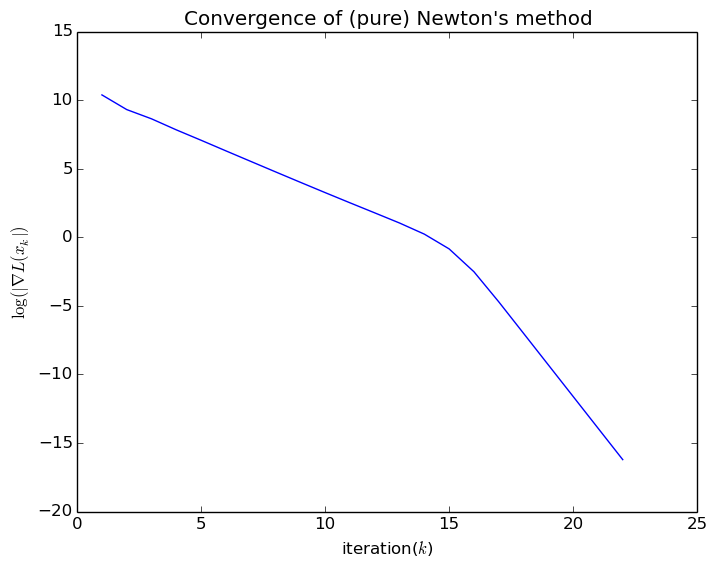

PyObject <matplotlib.text.Text object at 0x7f0dd75e3e50>

In [24]:
plot(1:length(G),log(G))
title("Convergence of (pure) Newton's method")
xlabel(L"iteration($k$)")
ylabel(L"$\log(\|\nabla L(x_k\|)$")

For the modified Newton's method: 

In [13]:
x0=ones(3)
x,its,G=newtmin(obj2,x0,"modified2",r=0.5,eps=1,optTol=1e-6)
println("Its=",its,", The optimal value=",obj2(x)[1])
println("x=",x)

Its=33, The optimal value=240.1719908430274
x=[-4.9493442124964835,0.002690681887937538,0.7546778789633789]


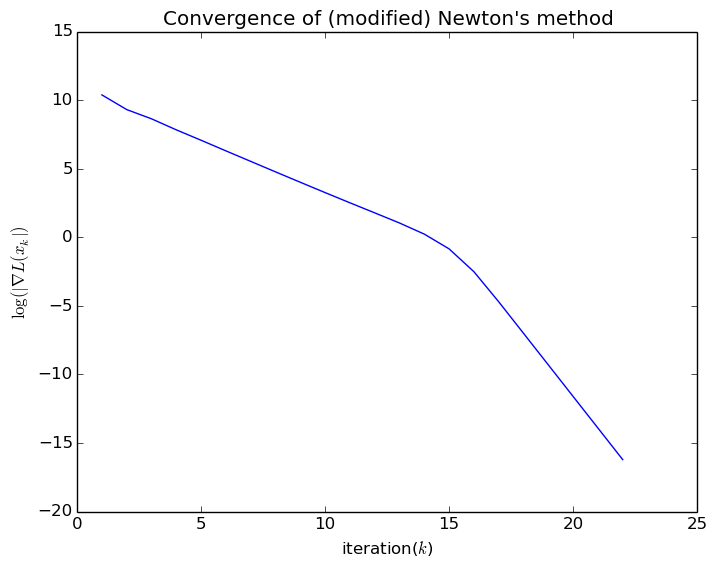

PyObject <matplotlib.text.Text object at 0x7f0dd74fa910>

In [25]:
plot(1:length(G),log(G))
title("Convergence of (modified) Newton's method")
xlabel(L"iteration($k$)")
ylabel(L"$\log(\|\nabla L(x_k\|)$")

For the BFGS method:

In [29]:
x0=zeros(3)
x,its,G=newtmin(obj2,x0,"bfgs";eps=1,maxIts=100,optTol=1e-6)
println("Its=",its,", The optimal value=",obj2(x)[1])
println("x=",x)

Its=7, The optimal value=240.17199084247497
x=[-4.949367897168008,0.0026906767490640442,0.7546852523274458]


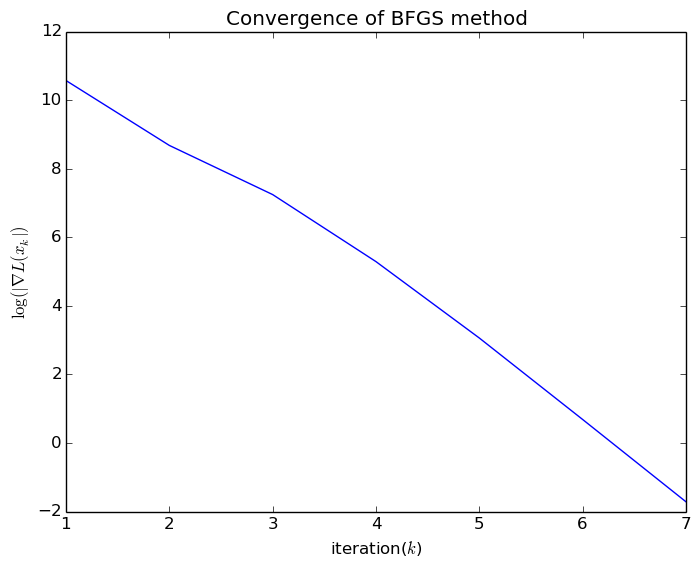

PyObject <matplotlib.text.Text object at 0x7f0dd72b1890>

In [30]:
plot(1:length(G),log(G))
title("Convergence of BFGS method")
xlabel(L"iteration($k$)")
ylabel(L"$\log(\|\nabla L(x_k\|)$")

In [35]:
x0=[-2,0,2]
x,its,G=newtmin(obj2,x0,"bfgs";eps=1,maxIts=100,optTol=1e-6)
println("Its=",its,", The optimal value=",obj2(x)[1])
println("x=",x)

Its=13, The optimal value=240.17199084242242
x=[-4.949377676356873,0.0026906832154044566,0.7546866855998055]


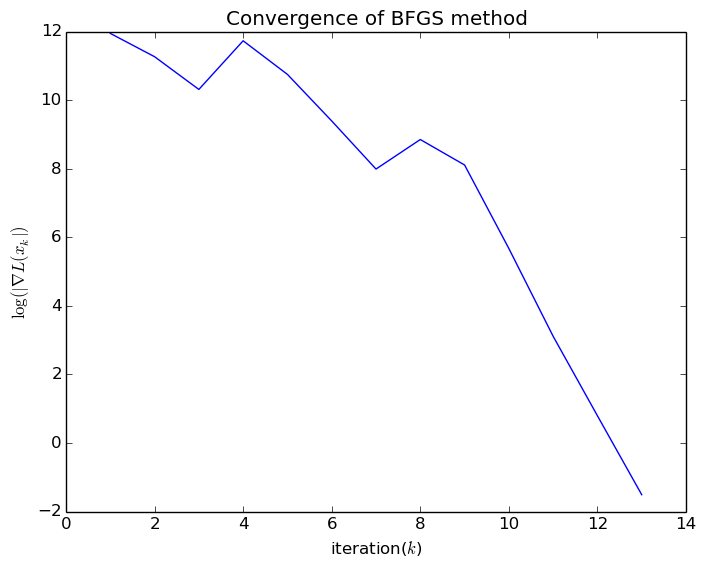

PyObject <matplotlib.text.Text object at 0x7f0dd487e950>

In [36]:
plot(1:length(G),log(G))
title("Convergence of BFGS method")
xlabel(L"iteration($k$)")
ylabel(L"$\log(\|\nabla L(x_k\|)$")

For the gradient descent method

In [37]:
u2=u*Diagonal([1/200,1])
X=[ones(400) u2]
alpha=4/norm(X)^2

0.00046683276468109826

From the results above and the results in last homework: the iteration of the second-order method is less than 40, but the iteration of the first-order method is approximately 50000, i.e. the second-order method is more faster than the first-order method.